In [1]:
import pandas as pd
import numpy as np
import json

In [14]:
data = []

with open(r'C:\Users\hsee\OneDrive - LMR Partners\Documents\compression\v2\updates_12am_decode.json', 'r') as f:
    x = f.read()



In [21]:
import pandas as pd
from pathlib import Path


# Minimal rebuild (copy/paste from above would be redundant)
import json
from decimal import Decimal
from collections import defaultdict
import math

def split_json_arrays(text: str):
    arrays, i, n = [], 0, len(text)
    while i < n:
        while i < n and text[i].isspace():
            i += 1
        if i >= n:
            break
        if text[i] != '[':
            i += 1
            continue
        depth = 0
        start = i
        in_string = False
        escape = False
        while i < n:
            ch = text[i]
            if in_string:
                if escape:
                    escape = False
                elif ch == '\\':
                    escape = True
                elif ch == '"':
                    in_string = False
            else:
                if ch == '"':
                    in_string = True
                elif ch == '[':
                    depth += 1
                elif ch == ']':
                    depth -= 1
                    if depth == 0:
                        i += 1
                        arrays.append(text[start:i])
                        break
            i += 1
    return arrays

def parse_events_from_text(text: str):
    events = []
    for arr in split_json_arrays(text):
        try:
            payload = json.loads(arr)
            if isinstance(payload, list):
                for obj in payload:
                    if isinstance(obj, dict) and 'event_type' in obj:
                        events.append(obj)
        except json.JSONDecodeError:
            pass
    return events

def to_decimal(s):
    if s is None:
        return Decimal(0)
    if isinstance(s, (int, float)):
        return Decimal(str(s))
    return Decimal(str(s))

def normalize_book_list(levels):
    out = {}
    for lvl in levels or []:
        p = to_decimal(lvl.get("price"))
        sz = to_decimal(lvl.get("size"))
        out[p] = sz
    return out

def apply_book_snapshot(state, event):
    state["bids"] = normalize_book_list(event.get("bids", []))
    state["asks"] = normalize_book_list(event.get("asks", []))

def apply_price_change(state, event):
    SideMap = {"SELL":"asks","ASK":"asks","ASKS":"asks","BUY":"bids","BID":"bids","BIDS":"bids"}
    for ch in event.get("changes", []):
        side_key = SideMap.get(str(ch.get("side", "")).upper())
        if side_key not in ("bids", "asks"):
            continue
        p = to_decimal(ch.get("price"))
        sz = to_decimal(ch.get("size"))
        book = state[side_key]
        if sz <= 0:
            if p in book:
                del book[p]
        else:
            book[p] = sz

def level_pairs(state, top_n=5):
    bids = sorted(state["bids"].items(), key=lambda kv: kv[0], reverse=True)[:top_n]
    asks = sorted(state["asks"].items(), key=lambda kv: kv[0])[:top_n]
    return bids, asks

def fmt_num(d):
    if d is None:
        return None
    try:
        f = float(d)
        if math.isnan(f) or math.isinf(f):
            return None
        return f
    except Exception:
        return None

def build_df_from_events(events):
    def ts_val(e):
        try: return int(e.get("timestamp"))
        except Exception: return int(0)
    event_rank = {"book": 0, "price_change": 1, "last_trade_price": 2}
    events_sorted = sorted(events, key=lambda e: (ts_val(e), event_rank.get(e.get("event_type",""), 99)))
    by_ts = defaultdict(list)
    for e in events_sorted:
        by_ts[ts_val(e)].append(e)
    state = {"bids": {}, "asks": {}}
    rows, index = [], []
    for ts in sorted(by_ts.keys()):
        trade_notes = []
        for e in by_ts[ts]:
            et = e.get("event_type")
            if et == "book":
                apply_book_snapshot(state, e)
            elif et == "price_change":
                apply_price_change(state, e)
            elif et == "last_trade_price":
                side, size, price = e.get("side"), e.get("size"), e.get("price")
                if size is not None and price is not None and side is not None:
                    trade_notes.append((side, size, price))#f"{side} {size} @ {price}")
        bids, asks = level_pairs(state, top_n=5)
        row = {}
        for i in range(5):
            if i < len(bids):
                p, sz = bids[i]
                row[f"bid{i+1}_price"] = fmt_num(p)
                row[f"bid{i+1}_size"] = fmt_num(sz)
            else:
                row[f"bid{i+1}_price"] = None
                row[f"bid{i+1}_size"] = None
        for i in range(5):
            if i < len(asks):
                p, sz = asks[i]
                row[f"ask{i+1}_price"] = fmt_num(p)
                row[f"ask{i+1}_size"] = fmt_num(sz)
            else:
                row[f"ask{i+1}_price"] = None
                row[f"ask{i+1}_size"] = None
        row["trade"] = trade_notes
        rows.append(row)
        index.append(ts)
    return pd.DataFrame(rows, index=pd.Index(index, name="timestamp"))


events = parse_events_from_text(x)
df = build_df_from_events(events)

In [30]:
df.index = pd.to_datetime(df.index, unit = 'ms')

In [31]:
df

,bid1_price,bid1_size,bid2_price,bid2_size,bid3_price,bid3_size,bid4_price,bid4_size,bid5_price,bid5_size,...,ask1_size,ask2_price,ask2_size,ask3_price,ask3_size,ask4_price,ask4_size,ask5_price,ask5_size,trade
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-08-21 04:00:55.327,0.51,5.0,0.5,5090.0,0.49,106.3,0.48,20.0,0.47,210.0,...,500.00,0.56,15.7,0.58,5095.0,0.59,80.0,0.6,380.0,[]
2025-08-21 04:00:55.335,0.51,5.0,0.5,5090.0,0.49,106.3,0.48,20.0,0.47,210.0,...,500.00,0.56,15.7,0.58,5095.0,0.59,80.0,0.6,380.0,[]
2025-08-21 04:00:55.367,0.51,5.0,0.5,5090.0,0.49,106.3,0.48,20.0,0.47,210.0,...,500.00,0.56,15.7,0.58,5095.0,0.59,80.0,0.6,380.0,[]
2025-08-21 04:00:55.780,0.51,5.0,0.5,5090.0,0.49,106.3,0.48,10.0,0.47,210.0,...,500.00,0.56,15.7,0.58,5095.0,0.59,80.0,0.6,380.0,[]
2025-08-21 04:00:55.785,0.51,5.0,0.5,5090.0,0.49,106.3,0.48,10.0,0.47,210.0,...,500.00,0.56,15.7,0.58,5085.0,0.59,80.0,0.6,380.0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-21 05:08:01.122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33480.67,0.02,60.0,0.10,10.0,0.50,20.0,0.8,100.0,[]
2025-08-21 05:08:01.710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33480.67,0.02,60.0,0.10,10.0,0.50,20.0,0.8,100.0,[]
2025-08-21 05:08:02.714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33407.26,0.02,60.0,0.10,10.0,0.50,20.0,0.8,100.0,[]


In [35]:
print(df[df.trade.apply(lambda x: len(x) > 0)].head())

                         bid1_price  bid1_size  bid2_price  bid2_size  \
timestamp                                                               
2025-08-21 04:00:57.182        0.50      60.00        0.49     5015.0   
2025-08-21 04:01:20.270        0.48    5810.00        0.47      289.8   
2025-08-21 04:01:21.224        0.48    5410.00        0.47      289.8   
2025-08-21 04:01:32.445        0.49      40.00        0.48     6000.0   
2025-08-21 04:01:38.336        0.49      30.19        0.48     6000.0   

                         bid3_price  bid3_size  bid4_price  bid4_size  \
timestamp                                                               
2025-08-21 04:00:57.182        0.48       85.0        0.47      227.5   
2025-08-21 04:01:20.270        0.46       75.0        0.45       80.0   
2025-08-21 04:01:21.224        0.46       75.0        0.45       80.0   
2025-08-21 04:01:32.445        0.47      289.8        0.46       75.0   
2025-08-21 04:01:38.336        0.47      289.8    

In [36]:
import matplotlib.pyplot as plt

In [59]:
%matplotlib qt
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `df` is your DataFrame with a DateTimeIndex and the following columns:
# 'bid1_price', 'bid1_size', ..., 'bid5_price', 'bid5_size',
# 'ask1_price', 'ask1_size', ..., 'ask5_price', 'ask5_size',
# and an 'orders' column containing lists of tuples: (side, volume, price).

# Calculate spread and orderbook imbalance
# Spread: difference between best ask and best bid
spread = df['ask1_price'] - df['bid1_price']
# Imbalance: (sum of bid sizes - sum of ask sizes) / total size
bid_sizes = df[[f'bid{i}_size' for i in range(1, 6)]].mul([5, 4, 3, 2, 1], axis=1).sum(axis=1) # df[[f'bid{i}_size' for i in range(1, 6)]].sum(axis=1)
ask_sizes = df[[f'ask{i}_size' for i in range(1, 6)]].mul([5, 4, 3, 2, 1], axis=1).sum(axis=1)
imbalance = (bid_sizes - ask_sizes) / (bid_sizes + ask_sizes)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 10))

# 1. Main plot: bid/ask levels over time
for i in range(1, 2):
    ax1.plot(df.index, df[f'bid{i}_price'], color='green', alpha=0.6, label='Bid Levels' if i == 1 else "")
    ax1.plot(df.index, df[f'ask{i}_price'], color='red',   alpha=0.6, label='Ask Levels' if i == 1 else "")

# # Overlay order markers
for timestamp, orders in df['trade'].items():
    for side, volume, price in orders:
        if side == 'BUY':
            ax1.scatter(timestamp, float(price), marker='^', color='green', s=50, edgecolors='black')
        else:
            ax1.scatter(timestamp, float(price), marker='v', color='red',   s=50, edgecolors='black')

ax1.set_title('Orderbook Bid/Ask Levels with Trade Markers')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# 2. Subplot: Spread and Imbalance over time
ax2.scatter(df.index, imbalance, label='Imbalance', color='purple')
# ax2.plot(df.index, imbalance.rolling(30).mean(), label='Imbalance', color='purple')
ax2.set_ylabel('Imbalance')
# ax2_twin = ax2.twinx()
# ax2_twin.plot(df.index, imbalance, label='Imbalance', color='purple')
# ax2_twin.set_ylabel('Imbalance')

# Legends for second subplot
# lines, labels = ax2.get_legend_handles_labels()
# lines2, labels2 = ax2_twin.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='upper left')

ax2.set_title('Spread and Orderbook Imbalance Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [58]:
df.to_csv("data.csv")

In [48]:
!py -m pip install PyQt6

Defaulting to user installation because normal site-packages is not writeable
  Using cached pyqt6-6.9.1-cp39-abi3-win_amd64.whl.metadata (2.2 kB)
  Using cached pyqt6_sip-13.10.2-cp312-cp312-win_amd64.whl.metadata (515 bytes)
  Using cached pyqt6_qt6-6.9.1-py3-none-win_amd64.whl.metadata (551 bytes)
Using cached pyqt6-6.9.1-cp39-abi3-win_amd64.whl (25.7 MB)
Using cached pyqt6_qt6-6.9.1-py3-none-win_amd64.whl (73.8 MB)
Using cached pyqt6_sip-13.10.2-cp312-cp312-win_amd64.whl (53 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


<Axes: xlabel='timestamp'>

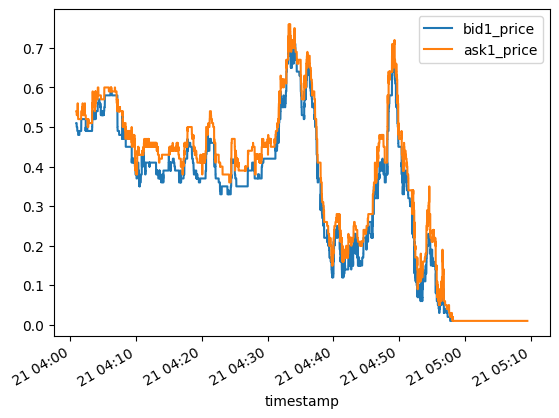

In [32]:
df[['bid1_price', 'ask1_price']].plot()